In [1]:
####SUCCESFUL: IMPORTANT

import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat


from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:2


In [ ]:
# def true_2D_1(xt): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
#     y = xt[:,0]*np.cos(xt[:,1])
#     return y.reshape(-1,1)    

In [2]:
#Material Properties This link - https://www.mathworks.com/help/pde/ug/nonlinear-heat-transfer-in-a-thin-plate.html#heatTransferThinPlateExample-1
k = 400
rho = 8960
cp = 386
t_z = 0.01
stef_bolt = 5.670373e-8
hc = 1
Ta = 300
emiss = 0.5


In [35]:
label = "Navier_stan"

x = np.linspace(0,1,250).reshape(-1,1)
y = np.linspace(0,1,250).reshape(-1,1)
#t = np.linspace(0,1,100).reshape(-1,1) #t is actually from 0 to 5000, let us scale it to 0 to 1

X,Y = np.meshgrid(x,y)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
 
xy = np.hstack((X,Y))

#initial_pts = np.logical_and(T==0,Y!=0).reshape(-1,)

DBC_pts = (Y == 0).reshape(-1,)


NBC_pts_x0 = (X == 0).reshape(-1,)
NBC_pts_x1 = (X == 1).reshape(-1,)

NBC_pts_y0 = (Y == 0).reshape(-1,)
NBC_pts_y1 = (Y == 1).reshape(-1,)

#xy_initial = xyt[initial_pts,:]
xy_DBC = xy[DBC_pts,:]

xy_NBC_x0 = xy[NBC_pts_x0,:]
xy_NBC_x1 = xy[NBC_pts_x1,:]

#xyt_NBC_y0 = xyt[NBC_pts_y0,:]
xy_NBC_y1 = xy[NBC_pts_y1,:]

#u_initial = np.zeros((np.shape(xy_initial)[0],1))
u_DBC = 1000*np.ones((np.shape(xy_DBC)[0],1))

#xy_I_DBC = np.vstack((xy_initial,xyt_DBC))
#xyt_NBC = np.vstack((xyt_NBC_1,xyt_NBC_2,xyt_NBC_3,xyt_NBC_4))
xy_NBC_x = np.vstack((xy_NBC_x0,xy_NBC_x1))
#xyt_NBC_y = np.vstack((xyt_NBC_y0,xyt_NBC_y1))
xy_NBC_y = np.vstack((xy_NBC_y1))

#u_I_DBC = np.vstack((u_initial,u_DBC))

xy_test_tensor = torch.from_numpy(xy).float().to(device)

lb_xy = xy[0]
ub_xy = xy[-1]

In [4]:
def trainingdata(N_D,N_N,N_f,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    
    #choose random N_u points for training
    idx = np.random.choice(xy_DBC.shape[0], N_D, replace=False) 
    xy_D = xy_DBC[idx,:] #choose indices from  set 'idx' (x,t)
    u_D = u_DBC[idx].reshape(-1,1)      #choose corresponding u

    idx = np.random.choice(xy_NBC_x.shape[0], N_D, replace=False) 
    xy_Nx = xy_NBC_x[idx,:] #choose indices from  set 'idx' (x,t)

    idx = np.random.choice(xy_NBC_y.shape[0], N_D, replace=False) 
    xy_Ny = xy_NBC_y[idx,:] #choose indices from  set 'idx' (x,t)

    '''Collocation Points'''
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    
    xy_coll = lb_xy + (ub_xy - lb_xy)*samples
    xy_coll = np.vstack((xy_coll, xy_D,xy_Nx,xy_Ny)) # append training points to collocation points 

    return xy_coll, xy_D, u_D, xy_Nx,xy_Ny

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        self.beta = Parameter(torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
        
        self.train_loss = []
        self.test_loss = []
        
        self.beta_val = []
        
        self.n = torch.tensor(1.0)
            
    'foward pass'
    def forward(self,xy):
        if torch.is_tensor(xy) != True:         
            xy = torch.from_numpy(xy)                
        
        ubxy = torch.from_numpy(ub_xy).float().to(device)
        lbxy = torch.from_numpy(lb_xy).float().to(device)

                      
        #preprocessing input 
        xy = (xy - lbxy)/(ubxy - lbxy)
        
        #convert to float
        a = xy.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            z1 = self.activation(z) 
            a = z1 + self.beta[:,i]*z*z1
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_D(self,xy_D,u_D):
                
        loss_bc = self.loss_function(self.forward(xy_D), u_D)
                
        return loss_bc
    
    def loss_N(self,xy_Nx,xy_Ny,N_hat):
        
        g1 = xy_Nx.clone()             
        g1.requires_grad = True
        u1 = self.forward(g1)
        
        u1_x_y = autograd.grad(u1,g1,torch.ones([xy_Nx.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du1_dx = u1_x_y[:,[0]]
        
        g2 = xy_Ny.clone()             
        g2.requires_grad = True
        u2 = self.forward(g2)
        
        u2_x_y = autograd.grad(u2,g2,torch.ones([xy_Ny.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du2_dy = u2_x_y[:,[1]]
               
        loss_N1 = self.loss_function(du1_dx,N_hat)
        loss_N2 = self.loss_function(du2_dy,N_hat)
        
        #return loss_N1+loss_N2       
        return loss_N1 + loss_N2
    
    def loss_PDE(self, xy_coll, f_hat):
        
        g = xy_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y = autograd.grad(u,g,torch.ones([xy_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy = autograd.grad(u_x_y,g,torch.ones(xy_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        #du_dt = u_x_y_t[:,[2]]
        
        d2u_dx2 = u_xx_yy[:,[0]]
        d2u_dy2 = u_xx_yy[:,[1]]    
        

        f = - k*t_z*(d2u_dx2+d2u_dy2) + 2*hc*(u-Ta) + 2*emiss*stef_bolt*(torch.pow(u,4)-Ta**4) 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xy_D,u_D,xy_Nx,xy_Ny,N_hat,xy_coll,f_hat):

        loss_D = self.loss_D(xy_D,u_D)
        loss_N = self.loss_N(xy_Nx,xy_Ny,N_hat)
        loss_f = self.loss_PDE(xy_coll,f_hat)
        
        loss_val = loss_D + loss_N + loss_f
        
        #print(self.iter,"loss_D:",loss_D.cpu().detach().numpy(),"loss_N:",loss_N.cpu().detach().numpy(),"loss_f:",loss_f.cpu().detach().numpy())
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        optimizer.zero_grad()
        
        loss = self.loss(xy_D,u_D,xy_Nx,xy_Ny,N_hat,xy_coll,f_hat)
        self.train_loss.append(loss.cpu().detach().numpy())
        
        u_pred = self.test(xy_test_tensor)
        #self.test_loss.append(np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))) #Commented because no true values yet
        self.beta_val.append(self.beta.cpu().detach().numpy())
        
        #print(self.iter,"Train Loss",self.train_loss[-1],"Test Loss",self.test_loss[-1])
        print(self.iter,"Train Loss",self.train_loss[-1])
        
        loss.backward()
        self.iter += 1
  

        return loss        
    'test neural network'
    def test(self,xy_test_tensor):
        u_pred = self.forward(xy_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

In [6]:
max_reps = 1

train_loss_full = []
test_loss_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))

for reps in range(max_reps):
    print(reps)
    
    torch.manual_seed(reps*36)
    N_D = 100 #Total number of data points for 'y'
    N_N = 3500
    N_f = 10000 #Total number of collocation points 
    
    xy_coll_np_array, xy_D_np_array, u_D_np_array,xy_Nx_np_array,xy_Ny_np_array = trainingdata(N_D,N_N,N_f,(reps)*22)
        
    xy_coll = torch.from_numpy(xy_coll_np_array).float().to(device)
    xy_D = torch.from_numpy(xy_D_np_array).float().to(device)
    u_D = torch.from_numpy(u_D_np_array).float().to(device)
    xy_Nx = torch.from_numpy(xy_Nx_np_array).float().to(device)
    xy_Ny = torch.from_numpy(xy_Ny_np_array).float().to(device)
        
    N_hat = torch.zeros(xy_Nx.shape[0],1).to(device)    
    f_hat = torch.zeros(xy_coll.shape[0],1).to(device)

    layers = np.array([2,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers
    #layers = np.array([3,100,100,100,100,100,100,100,1])

    PINN = Sequentialmodel(layers)
   
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                              max_iter = 10000, 
                              max_eval = None, 
                              tolerance_grad = -1, 
                              tolerance_change = -1, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')



    start_time = time.time()
        
    optimizer.step(PINN.closure)
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(PINN.train_loss)
    test_loss_full.append(PINN.test_loss)
    elapsed_time[reps] = time.time() - start_time
    beta_full.append(PINN.beta_val)


    print('Training time: %.2f' % (elapsed_time[reps]))
    
mdic = {"train_loss": train_loss_full,"test_loss": test_loss_full,"Time": elapsed_time, "beta": beta_full, "label": label}
savemat(label+'.mat', mdic)

0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0 Train Loss 2134119.0
1 Train Loss 2130068.5
2 Train Loss 2105508.2
3 Train Loss 2058562.6
4 Train Loss 2043182.8
5 Train Loss 2025923.5
6 Train Loss 1986442.9
7 Train Loss 1891697.0
8 Train Loss 1768869.8
9 Train Loss 15808501.0
10 Train Loss 1726310.0
11 Train Loss 1976480.0
12 Train Loss 1660680

311 Train Loss 4214.189
312 Train Loss 4135.432
313 Train Loss 4085.1638
314 Train Loss 4024.063
315 Train Loss 3926.8115
316 Train Loss 3843.1387
317 Train Loss 3757.1738
318 Train Loss 3708.0237
319 Train Loss 3680.9207
320 Train Loss 3656.2686
321 Train Loss 3615.21
322 Train Loss 3521.1123
323 Train Loss 3463.695
324 Train Loss 3359.656
325 Train Loss 3267.319
326 Train Loss 3108.8599
327 Train Loss 2975.3037
328 Train Loss 3461.1855
329 Train Loss 2874.4038
330 Train Loss 2767.538
331 Train Loss 2626.5034
332 Train Loss 2582.9978
333 Train Loss 2489.4512
334 Train Loss 2431.7969
335 Train Loss 2388.106
336 Train Loss 2330.2075
337 Train Loss 2260.6343
338 Train Loss 2137.0513
339 Train Loss 2041.3892
340 Train Loss 5463.5747
341 Train Loss 2010.4614
342 Train Loss 1921.4926
343 Train Loss 1827.291
344 Train Loss 1773.4108
345 Train Loss 1732.3405
346 Train Loss 1687.7659
347 Train Loss 1698.1304
348 Train Loss 1655.7991
349 Train Loss 1842.7776
350 Train Loss 1643.6732
351 Train L

643 Train Loss 133.34811
644 Train Loss 133.42908
645 Train Loss 133.11078
646 Train Loss 132.34157
647 Train Loss 131.87164
648 Train Loss 131.05551
649 Train Loss 130.43288
650 Train Loss 129.88309
651 Train Loss 129.23358
652 Train Loss 128.90076
653 Train Loss 128.54521
654 Train Loss 128.24002
655 Train Loss 127.91709
656 Train Loss 127.55344
657 Train Loss 127.3648
658 Train Loss 126.92574
659 Train Loss 126.82991
660 Train Loss 126.17215
661 Train Loss 126.04303
662 Train Loss 125.94836
663 Train Loss 125.61515
664 Train Loss 125.31784
665 Train Loss 125.11578
666 Train Loss 124.7723
667 Train Loss 124.64528
668 Train Loss 124.53885
669 Train Loss 124.38881
670 Train Loss 124.32803
671 Train Loss 124.285614
672 Train Loss 124.233734
673 Train Loss 124.19586
674 Train Loss 124.15355
675 Train Loss 124.1013
676 Train Loss 124.05466
677 Train Loss 123.95363
678 Train Loss 123.8512
679 Train Loss 123.70108
680 Train Loss 123.542435
681 Train Loss 123.41837
682 Train Loss 123.32797
6

978 Train Loss 54.041977
979 Train Loss 53.960213
980 Train Loss 53.858242
981 Train Loss 53.828445
982 Train Loss 53.7529
983 Train Loss 53.64719
984 Train Loss 53.556694
985 Train Loss 53.443172
986 Train Loss 53.40487
987 Train Loss 53.174507
988 Train Loss 53.150738
989 Train Loss 52.91992
990 Train Loss 52.822903
991 Train Loss 52.664566
992 Train Loss 52.429474
993 Train Loss 52.35521
994 Train Loss 52.287212
995 Train Loss 52.208908
996 Train Loss 52.164467
997 Train Loss 52.110596
998 Train Loss 51.98934
999 Train Loss 51.839367
1000 Train Loss 51.60943
1001 Train Loss 53.337883
1002 Train Loss 51.516785
1003 Train Loss 51.33195
1004 Train Loss 51.264133
1005 Train Loss 51.037746
1006 Train Loss 50.929966
1007 Train Loss 51.143692
1008 Train Loss 50.862373
1009 Train Loss 50.763824
1010 Train Loss 50.68469
1011 Train Loss 50.615395
1012 Train Loss 50.582054
1013 Train Loss 50.537712
1014 Train Loss 50.440605
1015 Train Loss 50.33881
1016 Train Loss 50.44463
1017 Train Loss 50.2

1302 Train Loss 28.41839
1303 Train Loss 28.385502
1304 Train Loss 28.365654
1305 Train Loss 28.351448
1306 Train Loss 28.354443
1307 Train Loss 28.33342
1308 Train Loss 28.330936
1309 Train Loss 28.331192
1310 Train Loss 28.329891
1311 Train Loss 28.328918
1312 Train Loss 28.32341
1313 Train Loss 28.31662
1314 Train Loss 28.311104
1315 Train Loss 28.313906
1316 Train Loss 28.30343
1317 Train Loss 28.30563
1318 Train Loss 28.313692
1319 Train Loss 28.302486
1320 Train Loss 28.306347
1321 Train Loss 28.302502
1322 Train Loss 28.56991
1323 Train Loss 28.313808
1324 Train Loss 28.31231
1325 Train Loss 28.310932
1326 Train Loss 28.30312
1327 Train Loss 28.56991
1328 Train Loss 28.313808
1329 Train Loss 28.31231
1330 Train Loss 28.310932
1331 Train Loss 28.30312
1332 Train Loss 28.56991
1333 Train Loss 28.313808
1334 Train Loss 28.31231
1335 Train Loss 28.310932
1336 Train Loss 28.30312
1337 Train Loss 28.56991
1338 Train Loss 28.313808
1339 Train Loss 28.31231
1340 Train Loss 28.310932
134

1625 Train Loss 28.310932
1626 Train Loss 28.30312
1627 Train Loss 28.56991
1628 Train Loss 28.313808
1629 Train Loss 28.31231
1630 Train Loss 28.310932
1631 Train Loss 28.30312
1632 Train Loss 28.56991
1633 Train Loss 28.313808
1634 Train Loss 28.31231
1635 Train Loss 28.310932
1636 Train Loss 28.30312
1637 Train Loss 28.56991
1638 Train Loss 28.313808
1639 Train Loss 28.31231
1640 Train Loss 28.310932
1641 Train Loss 28.30312
1642 Train Loss 28.56991
1643 Train Loss 28.313808
1644 Train Loss 28.31231
1645 Train Loss 28.310932
1646 Train Loss 28.30312
1647 Train Loss 28.56991
1648 Train Loss 28.313808
1649 Train Loss 28.31231
1650 Train Loss 28.310932
1651 Train Loss 28.30312
1652 Train Loss 28.56991
1653 Train Loss 28.313808
1654 Train Loss 28.31231
1655 Train Loss 28.310932
1656 Train Loss 28.30312
1657 Train Loss 28.56991
1658 Train Loss 28.313808
1659 Train Loss 28.31231
1660 Train Loss 28.310932
1661 Train Loss 28.30312
1662 Train Loss 28.56991
1663 Train Loss 28.313808
1664 Trai

1950 Train Loss 28.310932
1951 Train Loss 28.30312
1952 Train Loss 28.56991
1953 Train Loss 28.313808
1954 Train Loss 28.31231
1955 Train Loss 28.310932
1956 Train Loss 28.30312
1957 Train Loss 28.56991
1958 Train Loss 28.313808
1959 Train Loss 28.31231
1960 Train Loss 28.310932
1961 Train Loss 28.30312
1962 Train Loss 28.56991
1963 Train Loss 28.313808
1964 Train Loss 28.31231
1965 Train Loss 28.310932
1966 Train Loss 28.30312
1967 Train Loss 28.56991
1968 Train Loss 28.313808
1969 Train Loss 28.31231
1970 Train Loss 28.310932
1971 Train Loss 28.30312
1972 Train Loss 28.56991
1973 Train Loss 28.313808
1974 Train Loss 28.31231
1975 Train Loss 28.310932
1976 Train Loss 28.30312
1977 Train Loss 28.56991
1978 Train Loss 28.313808
1979 Train Loss 28.31231
1980 Train Loss 28.310932
1981 Train Loss 28.30312
1982 Train Loss 28.56991
1983 Train Loss 28.313808
1984 Train Loss 28.31231
1985 Train Loss 28.310932
1986 Train Loss 28.30312
1987 Train Loss 28.56991
1988 Train Loss 28.313808
1989 Trai

2273 Train Loss 28.313808
2274 Train Loss 28.31231
2275 Train Loss 28.310932
2276 Train Loss 28.30312
2277 Train Loss 28.56991
2278 Train Loss 28.313808
2279 Train Loss 28.31231
2280 Train Loss 28.310932
2281 Train Loss 28.30312
2282 Train Loss 28.56991
2283 Train Loss 28.313808
2284 Train Loss 28.31231
2285 Train Loss 28.310932
2286 Train Loss 28.30312
2287 Train Loss 28.56991
2288 Train Loss 28.313808
2289 Train Loss 28.31231
2290 Train Loss 28.310932
2291 Train Loss 28.30312
2292 Train Loss 28.56991
2293 Train Loss 28.313808
2294 Train Loss 28.31231
2295 Train Loss 28.310932
2296 Train Loss 28.30312
2297 Train Loss 28.56991
2298 Train Loss 28.313808
2299 Train Loss 28.31231
2300 Train Loss 28.310932
2301 Train Loss 28.30312
2302 Train Loss 28.56991
2303 Train Loss 28.313808
2304 Train Loss 28.31231
2305 Train Loss 28.310932
2306 Train Loss 28.30312
2307 Train Loss 28.56991
2308 Train Loss 28.313808
2309 Train Loss 28.31231
2310 Train Loss 28.310932
2311 Train Loss 28.30312
2312 Trai

2596 Train Loss 28.30312
2597 Train Loss 28.56991
2598 Train Loss 28.313808
2599 Train Loss 28.31231
2600 Train Loss 28.310932
2601 Train Loss 28.30312
2602 Train Loss 28.56991
2603 Train Loss 28.313808
2604 Train Loss 28.31231
2605 Train Loss 28.310932
2606 Train Loss 28.30312
2607 Train Loss 28.56991
2608 Train Loss 28.313808
2609 Train Loss 28.31231
2610 Train Loss 28.310932
2611 Train Loss 28.30312
2612 Train Loss 28.56991
2613 Train Loss 28.313808
2614 Train Loss 28.31231
2615 Train Loss 28.310932
2616 Train Loss 28.30312
2617 Train Loss 28.56991
2618 Train Loss 28.313808
2619 Train Loss 28.31231
2620 Train Loss 28.310932
2621 Train Loss 28.30312
2622 Train Loss 28.56991
2623 Train Loss 28.313808
2624 Train Loss 28.31231
2625 Train Loss 28.310932
2626 Train Loss 28.30312
2627 Train Loss 28.56991
2628 Train Loss 28.313808
2629 Train Loss 28.31231
2630 Train Loss 28.310932
2631 Train Loss 28.30312
2632 Train Loss 28.56991
2633 Train Loss 28.313808
2634 Train Loss 28.31231
2635 Train

2919 Train Loss 28.31231
2920 Train Loss 28.310932
2921 Train Loss 28.30312
2922 Train Loss 28.56991
2923 Train Loss 28.313808
2924 Train Loss 28.31231
2925 Train Loss 28.310932
2926 Train Loss 28.30312
2927 Train Loss 28.56991
2928 Train Loss 28.313808
2929 Train Loss 28.31231
2930 Train Loss 28.310932
2931 Train Loss 28.30312
2932 Train Loss 28.56991
2933 Train Loss 28.313808
2934 Train Loss 28.31231
2935 Train Loss 28.310932
2936 Train Loss 28.30312
2937 Train Loss 28.56991
2938 Train Loss 28.313808
2939 Train Loss 28.31231
2940 Train Loss 28.310932
2941 Train Loss 28.30312
2942 Train Loss 28.56991
2943 Train Loss 28.313808
2944 Train Loss 28.31231
2945 Train Loss 28.310932
2946 Train Loss 28.30312
2947 Train Loss 28.56991
2948 Train Loss 28.313808
2949 Train Loss 28.31231
2950 Train Loss 28.310932
2951 Train Loss 28.30312
2952 Train Loss 28.56991
2953 Train Loss 28.313808
2954 Train Loss 28.31231
2955 Train Loss 28.310932
2956 Train Loss 28.30312
2957 Train Loss 28.56991
2958 Train

3242 Train Loss 28.56991
3243 Train Loss 28.313808
3244 Train Loss 28.31231
3245 Train Loss 28.310932
3246 Train Loss 28.30312
3247 Train Loss 28.56991
3248 Train Loss 28.313808
3249 Train Loss 28.31231
3250 Train Loss 28.310932
3251 Train Loss 28.30312
3252 Train Loss 28.56991
3253 Train Loss 28.313808
3254 Train Loss 28.31231
3255 Train Loss 28.310932
3256 Train Loss 28.30312
3257 Train Loss 28.56991
3258 Train Loss 28.313808
3259 Train Loss 28.31231
3260 Train Loss 28.310932
3261 Train Loss 28.30312
3262 Train Loss 28.56991
3263 Train Loss 28.313808
3264 Train Loss 28.31231
3265 Train Loss 28.310932
3266 Train Loss 28.30312
3267 Train Loss 28.56991
3268 Train Loss 28.313808
3269 Train Loss 28.31231
3270 Train Loss 28.310932
3271 Train Loss 28.30312
3272 Train Loss 28.56991
3273 Train Loss 28.313808
3274 Train Loss 28.31231
3275 Train Loss 28.310932
3276 Train Loss 28.30312
3277 Train Loss 28.56991
3278 Train Loss 28.313808
3279 Train Loss 28.31231
3280 Train Loss 28.310932
3281 Trai

3569 Train Loss 28.31231
3570 Train Loss 28.310932
3571 Train Loss 28.30312
3572 Train Loss 28.56991
3573 Train Loss 28.313808
3574 Train Loss 28.31231
3575 Train Loss 28.310932
3576 Train Loss 28.30312
3577 Train Loss 28.56991
3578 Train Loss 28.313808
3579 Train Loss 28.31231
3580 Train Loss 28.310932
3581 Train Loss 28.30312
3582 Train Loss 28.56991
3583 Train Loss 28.313808
3584 Train Loss 28.31231
3585 Train Loss 28.310932
3586 Train Loss 28.30312
3587 Train Loss 28.56991
3588 Train Loss 28.313808
3589 Train Loss 28.31231
3590 Train Loss 28.310932
3591 Train Loss 28.30312
3592 Train Loss 28.56991
3593 Train Loss 28.313808
3594 Train Loss 28.31231
3595 Train Loss 28.310932
3596 Train Loss 28.30312
3597 Train Loss 28.56991
3598 Train Loss 28.313808
3599 Train Loss 28.31231
3600 Train Loss 28.310932
3601 Train Loss 28.30312
3602 Train Loss 28.56991
3603 Train Loss 28.313808
3604 Train Loss 28.31231
3605 Train Loss 28.310932
3606 Train Loss 28.30312
3607 Train Loss 28.56991
3608 Train

3894 Train Loss 28.31231
3895 Train Loss 28.310932
3896 Train Loss 28.30312
3897 Train Loss 28.56991
3898 Train Loss 28.313808
3899 Train Loss 28.31231
3900 Train Loss 28.310932
3901 Train Loss 28.30312
3902 Train Loss 28.56991
3903 Train Loss 28.313808
3904 Train Loss 28.31231
3905 Train Loss 28.310932
3906 Train Loss 28.30312
3907 Train Loss 28.56991
3908 Train Loss 28.313808
3909 Train Loss 28.31231
3910 Train Loss 28.310932
3911 Train Loss 28.30312
3912 Train Loss 28.56991
3913 Train Loss 28.313808
3914 Train Loss 28.31231
3915 Train Loss 28.310932
3916 Train Loss 28.30312
3917 Train Loss 28.56991
3918 Train Loss 28.313808
3919 Train Loss 28.31231
3920 Train Loss 28.310932
3921 Train Loss 28.30312
3922 Train Loss 28.56991
3923 Train Loss 28.313808
3924 Train Loss 28.31231
3925 Train Loss 28.310932
3926 Train Loss 28.30312
3927 Train Loss 28.56991
3928 Train Loss 28.313808
3929 Train Loss 28.31231
3930 Train Loss 28.310932
3931 Train Loss 28.30312
3932 Train Loss 28.56991
3933 Train

4221 Train Loss 28.30312
4222 Train Loss 28.56991
4223 Train Loss 28.313808
4224 Train Loss 28.31231
4225 Train Loss 28.310932
4226 Train Loss 28.30312
4227 Train Loss 28.56991
4228 Train Loss 28.313808
4229 Train Loss 28.31231
4230 Train Loss 28.310932
4231 Train Loss 28.30312
4232 Train Loss 28.56991
4233 Train Loss 28.313808
4234 Train Loss 28.31231
4235 Train Loss 28.310932
4236 Train Loss 28.30312
4237 Train Loss 28.56991
4238 Train Loss 28.313808
4239 Train Loss 28.31231
4240 Train Loss 28.310932
4241 Train Loss 28.30312
4242 Train Loss 28.56991
4243 Train Loss 28.313808
4244 Train Loss 28.31231
4245 Train Loss 28.310932
4246 Train Loss 28.30312
4247 Train Loss 28.56991
4248 Train Loss 28.313808
4249 Train Loss 28.31231
4250 Train Loss 28.310932
4251 Train Loss 28.30312
4252 Train Loss 28.56991
4253 Train Loss 28.313808
4254 Train Loss 28.31231
4255 Train Loss 28.310932
4256 Train Loss 28.30312
4257 Train Loss 28.56991
4258 Train Loss 28.313808
4259 Train Loss 28.31231
4260 Train

KeyboardInterrupt: 

In [36]:
u_pred = PINN.test(xy_test_tensor)
u_pred_3d = u_pred.reshape(250,250)

In [7]:
fig, ax = plt.subplots(1,1)
cmap = plt.cm.jet

img3 = ax.imshow(np.flipud(np.transpose(u_pred_3d)),vmax =1000,vmin=450,cmap = cmap,extent=[0,1,0,1],aspect = 1)
fig.colorbar(img3, orientation='vertical')

NameError: name 'plt' is not defined

In [18]:
mat = scipy.io.loadmat('Thinplate_steady.mat')
xy_test = np.array(mat['xy_test'])

u_test = np.array(mat['u_test'])
xy_test_tensor = torch.from_numpy(xy_test).float().to(device)
u_pred = PINN.test(xy_test_tensor)

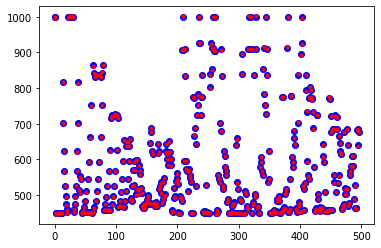

In [32]:
plt.plot(u_test,'bo')
plt.plot(u_pred,'ro',markersize = 3)

In [25]:
np.linalg.norm(u_pred-u_test)/np.linalg.norm(u_test)

0.0016613590458503691

SyntaxError: invalid syntax (<ipython-input-12-af732ad11e54>, line 1)

In [ ]:
a = 0
for i in range(10):
    a = a + test_loss_full[i][-1]
print(a/10)

In [ ]:
a = 0
for i in range(10):
    a = a + train_loss_full[i][-1]
print(a/10)

In [2]:
import numpy as np
l1 =np.array([1,2,3,4,5])
l2 =np.array([1,2,3,4,5])

In [4]:
L1,L2 = np.meshgrid(l1,l2)

In [6]:
L1

array([[1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5]])